In [40]:
import os
os.getcwd()

'C:\\Users\\dcw10\\Python jupyter code\\Tensorflow Tutorial\\Convolutional Auto Encoder\\libs'

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils import weight_variable, bias_variable
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
print("Packages loaded")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Packages loaded


# 建立convolution與deconvolutional layer
Encoder的部分有convolutional layer , Decoder的部分有deconvolutional layer <br>
建立一個包含兩層encoder以及兩層decoder的Convolutional 自編碼器

各層輸出的維度比較:

x 維度: 28 * 28，channel: 1 <br>
encoder layer1 維度: 14 * 14，channel: 16 <br>
encoder_layer2 維度: 7 * 7，channel: 32  <br>
decoder_layer1 維度: 14 * 14，channel: 16 <br>
decoder_layer2 維度: 28 * 28，channel: 1 <br>
x recontruct = decoder_layer2 <br>

(tf.nn.conv2d_transpose 的參數跟 tf.nn.conv2d 很像，只是要多一個 output_shape)

In [4]:
def conv2d(x, W): #convolutional layer
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape): #deconvolutional layer
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

# Build compute graph

In [44]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

code_layer = h_e_conv2
print("code layer shape : %s" % h_e_conv2.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")
output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 14, 14, 16])
h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, W_d_conv1, output_shape_d_conv1))

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")
output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 28, 28, 1])
h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

x_reconstruct = h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())


code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, 28, 28, 1)


# 建立Cost function


In [50]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

# Training

In [51]:
sess = tf.InteractiveSession()
batch_size = 60
init_op = tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch = mnist.train.next_batch(batch_size)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images}))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 0.101545
step 100, loss 0.0359529
step 200, loss 0.017533
step 300, loss 0.0165007
step 400, loss 0.0168763
step 500, loss 0.0150149
step 600, loss 0.0157801
step 700, loss 0.0161237
step 800, loss 0.0154118
step 900, loss 0.014689
step 1000, loss 0.0147519
step 1100, loss 0.014394
step 1200, loss 0.00202478
step 1300, loss 0.00166783
step 1400, loss 0.00171631
step 2000, loss 0.0015989
step 3000, loss 0.00132002
step 4000, loss 0.000967559
final loss 0.001153


# Plot reconstructed images

In [52]:
def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

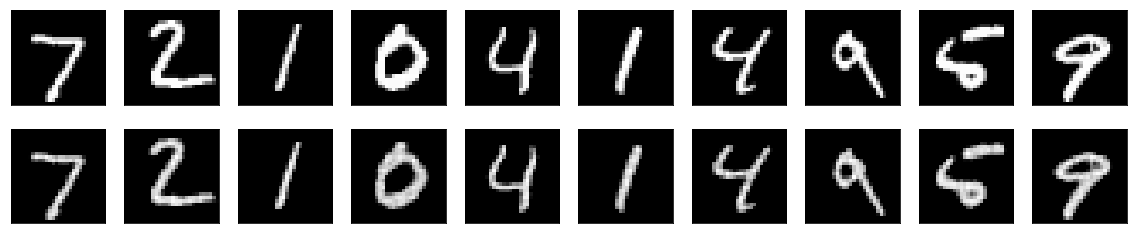

In [53]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

In [58]:
code_layer


<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 32) dtype=float32>